# Encoder-only architecture - BERT

## 1. Introduction

This notebook will walk through the basics of the BERT architecture, how its tokenizer works, and how positional encoding is applied.

BERT ([Bidirectional Encoder Representations from Transformers](https://arxiv.org/pdf/1810.04805)) is a transformer-based model designed for NLP tasks. It has multiple layers of encoders, each containing:
- Self-attention mechanism
- Feed-forward neural networks
- Layer normalization and residual connections

There are different sizes of BERT available:
- BERT base: 12 layers (transformer blocks), 768 hidden units, 12 self-attention heads
- BERT large: 24 layers, 1024 hidden units, 16 self-attention heads

In addition, a cased and an uncased version of BERT are available. The cased version retains the original case of the input text, while the uncased version converts all characters to lowercase.

We will focus on the base version of BERT, in uncased form. In HuggingFace, this model is called `bert-base-uncased`.

We'll start by visualizing the structure of BERT's encoders.

In [1]:
from transformers import BertModel, BertTokenizer
import torch
import matplotlib.pyplot as plt

model_name = "bert-base-uncased"

# TODO: Load pre-trained BERT model
model = BertModel.from_pretrained(model_name)

print(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### 1. **Embeddings Layer**
The embeddings layer is responsible for creating representations of the input tokens. It includes:

- **Word Embeddings**: Maps each of the 30,522 vocabulary tokens to a 768-dimensional vector.
- **Position Embeddings**: Adds positional information to each token using a 512-length sequence of 768-dimensional vectors (in other words, BERT supports at most 512 tokens in the input sequence)
- **Token Type Embeddings**: Adds embeddings to distinguish between segments (e.g., Sentence A and Sentence B) with 2 different token types (remember: BERT allows passing a pair of sentences, separated by a `[SEP]` token. This is used, we will see, for the Next Sentence Prediction task).
- **Layer Normalization and Dropout**: Normalizes the embeddings and applies dropout to prevent overfitting.

### 2. **BERT Encoder**
BERT's encoder is composed of 12 layers (for BERT base). The layers are implemented in the **BERTLayer** class. Each BERT layer consists of the following components:

- **Self-Attention**:
  - The self-attention mechanism is divided into multiple heads, each computing its own attention scores using three linear projections: Query (`Q`), Key (`K`), and Value (`V`). As with T5, the 12 attention heads are contained inside of a single liner layer (separately for Q, K, V) of size $12 \cdot 64 \times 768$ ($d_k = d_v = 64$).

- **Self-Attention Output**:
  - The output of the self-attention mechanism is passed through a dense (linear) layer that projects the output (concatenation of the 12 attention heads outputs) back to the original dimension of 768.

- **Feed-Forward Neural Network**:
  - Each BERT layer includes a feed-forward network that processes each token independently after the self-attention mechanism (we call this feed-forward network "position-wise" because, indeed, it is applied to each token indepedenly of the others).
  - This feed-forward network consists of two dense layers:
    - The **intermediate layer** expands the dimensionality from 768 to 3072 using a linear transformation and applies a **GELU** (Gaussian Error Linear Unit) activation function for non-linearity.
    - The **output layer** projects the 3072-dimensional vector back down to 768 dimensions, matching the input size.

- **Residual Connections**:
  - BERT uses residual (skip) connections around the self-attention and feed-forward components. The input to each sub-layer is added to its output.

In [2]:
# TODO: print the first layer of the BERT model

model.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

### **BERT Tokenization with WordPiece**

BERT uses a **WordPiece tokenizer**, a subword tokenization technique. This tokenizer splits words into smaller subwords or tokens, allowing BERT to represent rare words as combinations of common subwords and prefixes.

The WordPiece tokenizer splits words based on their frequencies in the training corpus, much like BPE.

- **Common Words**: If a word is frequently used in the training corpus, it will likely be stored as a single token. For example, words like "hello" or "sentence" are common enough to exist in BERT's vocabulary as single tokens.
- **Rare or Unknown Words**: For less common or out-of-vocabulary words, the tokenizer will break them into subword units or prefixes.

Subword continuation: The WordPiece tokenizer uses the `##` symbol to indicate that a token is a continuation of a previous token. For example, the word "happened" might be tokenized as "happen" and "##ed".

Let’s see how the WordPiece tokenizer processes a sample sentence using BERT’s tokenizer.


In [5]:
# Load pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

sentence = "hello, this is a sentence!"

# TODO: Tokenize the sentence
tokens = tokenizer.tokenize(sentence)
print("Tokens:", tokens)

# TODO: Convert tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", token_ids)

Tokens: ['hello', ',', 'this', 'is', 'a', 'sentence', '!']
Token IDs: [7592, 1010, 2023, 2003, 1037, 6251, 999]


In [6]:
sentence = "it was her responsibility to superintend the entire construction process"

# sentence = "hello, this is a sentence!"

# TODO: Tokenize the sentence
tokens = tokenizer.tokenize(sentence)
print("Tokens:", tokens)

# TODO: Convert tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", token_ids)

Tokens: ['it', 'was', 'her', 'responsibility', 'to', 'super', '##int', '##end', 'the', 'entire', 'construction', 'process']
Token IDs: [2009, 2001, 2014, 5368, 2000, 3565, 18447, 10497, 1996, 2972, 2810, 2832]


Note how the word "superintend", not found in BERT's vocabulary, is split into three subword tokens: `super`, `##int`, and `##end`.

Since `super` is the first token for the word, it is not prepended with `##`, whereas the others are. Note that, for instance, tokens `##end` and `end` (representing the self-contained word "end") are encoded as different tokens in BERT:



In [7]:
tokenizer.convert_tokens_to_ids(["##end", "end"])

[10497, 2203]

### Special Tokens in BERT

BERT uses several special tokens to structure the input and help the model understand the context and relationships between sequences. These tokens play an important role in various NLP tasks such as sentence classification, next sentence prediction, and more.

#### 1. **[CLS] Token** (Classification Token)
- The `[CLS]` token is added at the beginning of every input sequence.
- BERT uses this token as a representation of the entire sequence. The hidden state of the `[CLS]` token after passing through BERT can be used for classification tasks (we are going to use it later!).
- In the training of BERT, the output for the `[CLS]` token is used to build the binary classifier for the Next Sentence Prediction task.

#### 2. **[PAD] Token** (Padding Token)
- The `[PAD]` token is used to pad sequences so they all have the same length within a batch. The attention mechanism then ignores these `[PAD]` tokens.

In [8]:
sentence1 = "This is a short sentence."

# TODO: Tokenize the sentence with padding=True and max_length=10
tokens_single = tokenizer(sentence1, return_tensors='pt', padding='max_length', max_length=10)
# we ask the tokenizer to have a vector of 10 tokens, so it will add some padding tokens

# Display tokenized output and input IDs
print("Single Sentence Tokenization:")
print("Tokens:", tokenizer.convert_ids_to_tokens(tokens_single['input_ids'][0]))
print("Input IDs:", tokens_single['input_ids'][0])

Single Sentence Tokenization:
Tokens: ['[CLS]', 'this', 'is', 'a', 'short', 'sentence', '.', '[SEP]', '[PAD]', '[PAD]']
Input IDs: tensor([ 101, 2023, 2003, 1037, 2460, 6251, 1012,  102,    0,    0])


Notice that we use `max_length=10` to specify what the maximum length of sentences should be (in tokens). We additionally include `padding='max_length'`, which means that the tokenizer will add padding tokens (`[PAD]`) to the end of the sentence until it reaches the maximum length.

(Note that, if we want to truncate the sentences to `max_length` tokens, we should additionally pass `truncation=True`).

#### 3. **[SEP] Token** (Separator Token)
- The `[SEP]` token is used to separate segments (sentences) in BERT's input.
- It is especially important for tasks like Next Sentence Prediction (NSP) where BERT needs to understand the relationship between two sentences.
- It is also added at the end of the sequence to indicate its termination.

In [9]:
sentence2 = "But now it is a little longer."

# TODO: Tokenize the two sentences with padding and max_length of 20
# (You can pass a pair of sentences to the tokenizer as the first and
# second argument, they will be treateed as a pair of sentences separated by [SEP])
tokens_pair = tokenizer(sentence1, sentence2, return_tensors='pt', padding='max_length', max_length=20)

# Display tokenized output and input IDs
print("\nTwo Sentences Tokenization:")
print("Tokens:", tokenizer.convert_ids_to_tokens(tokens_pair['input_ids'][0]))
print("Input IDs:", tokens_pair['input_ids'][0])


Two Sentences Tokenization:
Tokens: ['[CLS]', 'this', 'is', 'a', 'short', 'sentence', '.', '[SEP]', 'but', 'now', 'it', 'is', 'a', 'little', 'longer', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
Input IDs: tensor([ 101, 2023, 2003, 1037, 2460, 6251, 1012,  102, 2021, 2085, 2009, 2003,
        1037, 2210, 2936, 1012,  102,    0,    0,    0])


Notice that now that we are passing two segments (Sentence A and Sentence B), the tokenizer returns also a `token_type_ids`.


In [10]:
tokens_pair["token_type_ids"] # Tells us which one is the first and second sentence

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])

This encodes information on which of the two sentences each token belongs to. This `token_type_ids` parameter is passed directly to the model's forward method, and the corresponding segment embeddings are added to the token embeddings.

#### 4. **[MASK] Token**
- The `[MASK]` token is used during training for the Masked Language Modeling (MLM) task, where a percentage of tokens are masked and the model must predict them based on the context.
- This token is rarely used during inference but is crucial in pre-training BERT.
- The `[MASK]` token (like other special tokens) can be included directly in the input text -- the tokenizer will assign the corresponding token.

In [11]:
# show a mask token
mask_token = tokenizer.mask_token
mask_token_id = tokenizer.convert_tokens_to_ids(mask_token)

# Encode a text
text = "I do not know how the sentence will [MASK]."

# TODO: Tokenize the text
tokens = tokenizer.tokenize(text)

# TODO: for each token, print the token and its ID
for token, token_id in zip(tokens, tokenizer.convert_tokens_to_ids(tokens)):
    print(f"{token} ({token_id})")


i (1045)
do (2079)
not (2025)
know (2113)
how (2129)
the (1996)
sentence (6251)
will (2097)
[MASK] (103)
. (1012)


### Positional Encodings in Transformers

There are two common approaches for implementing *absolute* positional encodings:

#### 1. **Static Sinusoidal Positional Encodings**

- A fixed vector is assigned to each absolute position in the sequence. For instance, the sinusoidal vectors used in AIAYN.
- **Advantages**:
  - This method requires no additional parameters or learning during training.
  - The same encoding can be applied across sequences of any length without adjustments.
- **Disadvantages**:
  - Since these encodings are static, they might not be as flexible or as specific as learned positional embeddings, which can adapt better to the data.

#### 2. **Learned Positional Embeddings**

- Instead of using a fixed, pre-defined encoding, learned positional embeddings are trained as part of the model, similar to how word embeddings are learned.
- The model learns a set of positional vectors, where each vector corresponds to a position in the sequence (one vector for position 0, one for position 1, etc.).
- **Advantages**:
  - The model can change positional encodings to the data it is trained on, potentially capturing positional relationships more effectively.
- **Disadvantages**:
  - Learned positional embeddings introduce additional parameters, which increases the model size and training complexity.
  - The learned embeddings are limited to a maximum sequence length (e.g., 512 for BERT).

BERT uses the second approach: **learned positional embeddings**. During the training process, BERT learns a set of positional vectors corresponding to token positions up to a maximum length (typically 512). These embeddings are added to the token embeddings to provide position information.


We can represent the matrix of cosine similarities between the positional embeddings to understand how the model "looks" at positions.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel

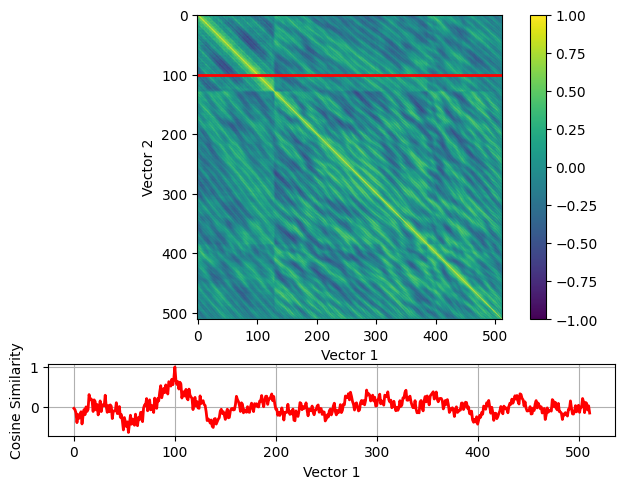

In [14]:
# TODO: Load pre-trained BERT model
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)

# TODO: Position embeddings are stored in the embedding layer as 'position_embeddings.weight'
positional_encodings = model.embeddings.position_embeddings.weight.detach().numpy()

# Compute cosine similarity between positional encodings
cosine_sim = cosine_similarity(positional_encodings)

fig, ax = plt.subplot_mosaic("""
AAA
AAA
AAA
BBB""")

plt.tight_layout()

# Plot the cosine similarity heatmap
ax["A"].set_aspect('equal')
cbar = ax["A"].imshow(cosine_sim, cmap='viridis', vmin=-1, vmax=1)
ax["A"].set_xlabel('Vector 1')
ax["A"].set_ylabel('Vector 2')
ax["A"].axhline(100, c='r', lw=2)
# add colorbar
fig.colorbar(cbar, ax=ax["A"])


# Plot the cosine similarity for a specific row

ax["B"].plot(cosine_sim[100], c='r', lw=2)
ax["B"].set_xlabel('Vector 1')
ax["B"].set_ylabel('Cosine Similarity')
ax["B"].grid()

First, we observe the expected trend on the main diagonal (close vectors have similar distances). However, unlike other situations we discussed in class, the other cosine similarities are a bit noisier. This is, in general, to be expected for learned positional encodings.

You can see another interesting aspect in the first 128x128 block, which we can report below for convenience.

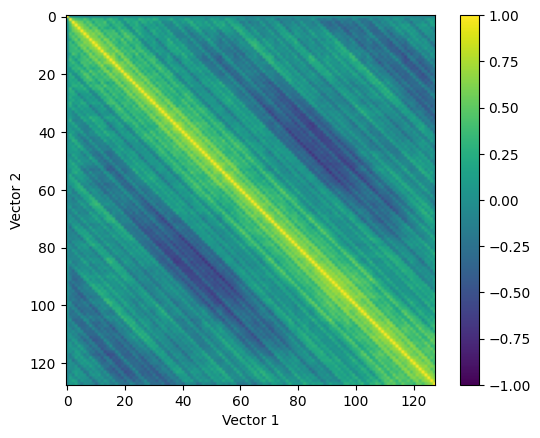

In [15]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
cbar = ax.imshow(cosine_sim[:128, :128], cmap='viridis', vmin=-1, vmax=1)
ax.set_xlabel('Vector 1')
ax.set_ylabel('Vector 2')
# add colorbar
fig.colorbar(cbar, ax=ax)

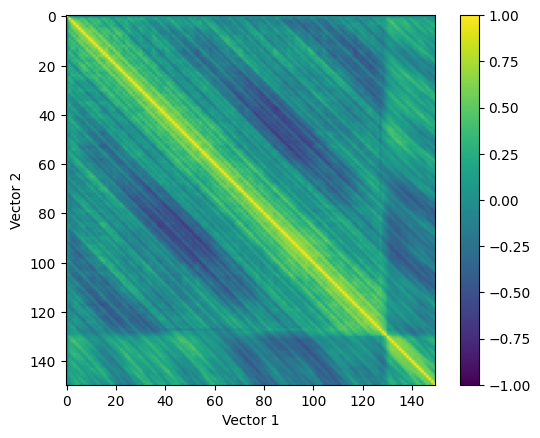

In [16]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
cbar = ax.imshow(cosine_sim[:150, :150], cmap='viridis', vmin=-1, vmax=1)
ax.set_xlabel('Vector 1')
ax.set_ylabel('Vector 2')
# add colorbar
fig.colorbar(cbar, ax=ax)

Notice that, for these 128x128 tokens, the matrix is much more structured (and somewhat resembles the one we already observed for GPT-2).

A likely explanation for this behavior can be found in BERT's paper:

> To speed up pretraing in our experiments, we pre-train the model with sequence length of 128 for 90% of the steps. Then, we train the rest 10% of the steps of sequence of 512 to learn the positional embeddings

This means that the first 128 positional tokens are learned for an extensive period of the training, whereas the remaining tokens are learned only for the ifnal 10% of steps. This is likely to produce better quality positional embeddings for the first 128 tokens, which is reflected in the cosine similarity matrix.

Finally, note that there are 2 segment embeddings as a part of BERT (`model.embeddings.token_type_embeddings`). These embeddings are used to distinguish between different segments in the input (e.g., Sentence A and Sentence B in the Next Sentence Prediction task).

In [ ]:
model.embeddings.token_type_embeddings.weight.shape

<span style="color:red">Extra stuff!</span>

We now know enough about BERT and transformer architectures to check where the 110M parameters of BERT base come from.

Let's break down the numbers:

- Embedding layers:
    - Token embeddings: 30,522 tokens x 768 dimensions = 23,440,896 parameters
    - Position embeddings: 512 positions x 768 dimensions = 393,216 parameters (almost negligible)
    - Segment embeddings: 2 segments x 768 dimensions = 1,536 parameters (definitely negligible)
    - Total: 23,440,896+393,216+1,536 = 23,835,648 parameters

- Encoder layers (12x):
    - $W_Q$, $W_K$, $W_V$: 768 dimensions x 768 dimensions + 768 biases = 590,592 parameters each (x3 = 1,771,776)
    - $W_O$: 768 dimensions x 768 dimensions + 768 biases = 590,592 parameters
    - Feed-forward network:
        - Intermediate layer: 768 dimensions x 3072 dimensions + 3072 biases = 2,362,368 parameters
        - Output layer: 3072 dimensions x 768 dimensions + 768 biases = 2,360,064 parameters
    - 2 Layer normalizations: 2 x 768 dimensions x 2 = 3,072 parameters (negligible)
    - Approx. total: 1,771,776+590,592 + 2,362,368 + 2,360,064 + 3,072 = 7,087,872 parameters

Total: 23,835,648 (embedding layers) + 12 x 7,087,872 (encoder layers) = 108,890,112 parameters

Which is close to the expected 110M parameters (especially if we include the various heads for various tasks, and some other parameters which we did not include here).

To get the answer directly from the model, we can use the following code.

In [ ]:
sum([ p.numel() for p in model.parameters () ])

## 2. BERT Pre-Training Tasks

BERT is pre-trained using two primary tasks: **Masked Language Modeling (MLM)** and **Next Sentence Prediction (NSP)**.

#### 1. **Masked Language Modeling (MLM)**

- In the MLM task, a fraction of tokens (15% in the original BERT work) is hidden by being replaced with the special `[MASK]` token. The model then tries to predict the original token based on the surrounding context.
- BERT learns to understand the context and fill in the blanks, which helps it develop contextualized embeddings for each word.

We can use `BertForMaskedLM` to load the BERT model with the appropriate head for the MLM task.


In [18]:
from transformers import BertForMaskedLM, BertForNextSentencePrediction
import torch

In [19]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'

# TODO: Load pre-trained BERT model for masked language modeling
model_mlm = BertForMaskedLM.from_pretrained(model_name)

print(model_mlm.cls)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertOnlyMLMHead(
  (predictions): BertLMPredictionHead(
    (transform): BertPredictionHeadTransform(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (transform_act_fn): GELUActivation()
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    )
    (decoder): Linear(in_features=768, out_features=30522, bias=True)
  )
)


Notice that the head has a final output with 30522 units, which will produce the probability distribution across all tokens. The same head is applied to predict all `[MASK]` tokens in the input sequence.

In [20]:
sentence = "I want to eat a [MASK]."

# TODO: Tokenize the sentence
inputs = tokenizer(sentence, return_tensors='pt')
print(inputs["input_ids"])

with torch.no_grad():

    # TODO: Get the model outputs
    outputs = model_mlm(**inputs)
    predictions = outputs.logits

print(predictions.shape)

tensor([[ 101, 1045, 2215, 2000, 4521, 1037,  103, 1012,  102]])
torch.Size([1, 9, 30522])


The output of BERT for the MLM task is 1x9x30522. 1 is (as always) the batch size (we are working with a single sentence). 9 is the number of tokens in the input sequence (including special tokens). 30522 is the size of the vocabulary.

Even though we have one output distribution for each input token, we only care about the probabilities for the `[MASK]` tokens. We can extract, for instance, the top 5 most likely tokens for each `[MASK]` token in the input sequence.

In [21]:
top_k = 5
mask = (inputs['input_ids'] == tokenizer.mask_token_id)
top_k_tokens = torch.argsort(predictions[mask], descending=True)[0, :top_k] # 0 => only take first mask

for token_id, token, logit in zip(top_k_tokens, tokenizer.convert_ids_to_tokens(top_k_tokens), predictions[mask][0, top_k_tokens]):
    print(f"{token} ({token_id}) - logit: {logit:.4f}")


little (2210) - logit: 10.2418
bite (6805) - logit: 9.8705
burger (15890) - logit: 9.0154
lot (2843) - logit: 8.9455
sandwich (11642) - logit: 8.6518


#### 2. **Next Sentence Prediction (NSP)**

- In addition to MLM, BERT is trained to predict whether one sentence logically follows another. This is called the **Next Sentence Prediction (NSP)** task.
- BERT takes two sentences (segments) as input and must determine if the second sentence is a continuation of the first.


In [22]:
model_nsp = BertForNextSentencePrediction.from_pretrained(model_name)

sentence_a = "Arthur Conan Doyle is my favorite author"
sentence_b = "I read all of his books" # natural continuation of the first one?

# TODO: Tokenize the two sentences
inputs_nsp = tokenizer(sentence_a, sentence_b, return_tensors='pt')

print("Tokens:", tokenizer.convert_ids_to_tokens(inputs_nsp['input_ids'][0]))

with torch.no_grad():

    # TODO: Get the model outputs
    outputs_nsp = model_nsp(**inputs_nsp)
    logits = outputs_nsp.logits
    probs = torch.softmax(logits, dim=1)

print(f"True: {probs[0,0].item():.6f}, False: {probs[0,1].item():.6f}")

Tokens: ['[CLS]', 'arthur', 'conan', 'doyle', 'is', 'my', 'favorite', 'author', '[SEP]', 'i', 'read', 'all', 'of', 'his', 'books', '[SEP]']
True: 0.999989, False: 0.000011


Everything is lower-cased!

In [23]:
# TODO: Tokenize the two sentences
sentence_c = "However, it's raining today"
inputs_nsp_false = tokenizer(sentence_a, sentence_c, return_tensors='pt')

print("Tokens:", tokenizer.convert_ids_to_tokens(inputs_nsp_false['input_ids'][0]))

with torch.no_grad():

    # TODO: Get the model outputs
    outputs_nsp = model_nsp(**inputs_nsp_false)
    logits = outputs_nsp.logits
    probs = torch.softmax(logits, dim=1)

print(f"True: {probs[0,0].item():.6f}, False: {probs[0,1].item():.6f}")

Tokens: ['[CLS]', 'arthur', 'conan', 'doyle', 'is', 'my', 'favorite', 'author', '[SEP]', 'however', ',', 'it', "'", 's', 'raining', 'today', '[SEP]']
True: 0.004302, False: 0.995698


## 3. Encoder Attention Mechanism

The attention mechanism is a crucial component of BERT’s encoder architecture. It allows the model to weigh the importance of each token in a sequence relative to all other tokens from both the left and right sides, making it **bidirectional**.

#### 1. **Self-Attention Mechanism**

In BERT, each token in a sequence attends to all other tokens, including itself. This is known as **self-attention**. The goal is to understand the relationship and relevance of each token within the entire sequence.


The attention mechanism allows BERT to dynamically weigh the relevance of each word in the context of the entire sequence. This helps BERT generate contextualized word representations that take into account the entire sentence.


Remember, each head of each layer has its own attention matrix. We can visualize all attention maps with a 12x12 plot.

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# TODO: Load pre-trained BERT model (with `output_attentions=True`) and tokenizer
model = ...
tokenizer = ...

sentence = "The dog ate the food because it was hungry"

# TODO: Tokenize the sentence
inputs = ...

# TODO: Get the model outputs
outputs = ...

attention = outputs.attentions  # This returns a list of attention matrices


`attention` contains a t uple with all of the attentions (one for each layer). Each attention is a tensor of shape (batch_size, num_heads, sequence_length, sequence_length).

In [ ]:
print("len(attention):", len(attention))
print("attention shape", attention[0].shape)

We can either visualize one specific layer+head, or we can visualize all possible attentions for all heads/layers.

In [ ]:
fig, ax = plt.subplots()

ax.imshow(attention[1][0, 1].detach().numpy(), cmap='viridis', aspect='equal')
ax.set_xticks(np.arange(len(inputs['input_ids'][0])), tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), rotation=90)
ax.set_yticks(np.arange(len(inputs['input_ids'][0])), tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]));

ax.set_xlabel("Attended token")
ax.set_ylabel("Attending token")

In [ ]:
fig, ax = plt.subplots(12, 12, figsize=(10, 10))

for i in range(12):
    for j in range(12):
        ax[i, j].imshow(attention[i][0, j].detach().numpy(), cmap='viridis', aspect='auto')
        ax[i, j].axis('off')

You can see that different attention layers and heads pay attention to different aspects. Can you spot heads where the model pays the "right" attention to word "it"? To what is the model paying the most attention?

## 4. BERT Fine-Tuning

While BERT is pre-trained on general tasks like Masked Language Modeling (MLM) and Next Sentence Prediction (NSP), we can **fine-tune** it on specific tasks. Fine-tuning involves training the pre-trained BERT model on a smaller dataset for a particular NLP task such as sentiment analysis, text classification, named entity recognition, or question answering.

The fine-tuning process typically involves:
- Adding a task-specific classification head (generally one or two dense layers + non-linearities suffice) on top of the pre-trained BERT model.
- Training the entire model (including both the BERT base and the new classification head) on your labeled dataset.
- The fine-tuning process adjusts the weights of the model so that it performs well on the new task, while still retaining the knowledge it gained during pre-training.

In this case, we’ll fine-tune BERT for a sentiment classification task. The model will be trained to classify movie reviews as positive or negative.

`BertForSequenceClassification` already introduces a classification head on top of the BERT model. We specify the number of classes (`num_labels`, 2 in this case) so that the library will already create the appropriate head for us.

In [24]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

In [25]:
# TODO: Load the pre-trained BERT model (with `num_labels=2`) and tokenizer
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(model_name)

# TODO: set the device to GPU if available and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model.classifier)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=2, bias=True)


In the HuggingFace transformers library, we can use the `Trainer` API to fine-tune the model. The `Trainer` API simplifies the training process by handling the training loop, logging, and evaluation.

We can define the training arguments, including the number of epochs, the learning rate, and the batch size. We also specify the evaluation strategy, which will run the evaluation on the validation set at the end of each epoch.

We need to define three things before we continue:
- an evaluation function that gives a metric of interest (for instance, accuracy)
- the training set, which will be used to fine-tune the model
- the validation set, which will be used to evaluate the model's performance

For the evaluation function, we implement a `compute_metrics` function that takes as input an object that contains the model's predictions (logits) and the ground truths. From this, we will return a dictionary of metric name, metric value pairs.

In [26]:
from sklearn.metrics import accuracy_score

# Function to compute accuracy

# instead of implementing our training loop from scratch, we create a trainer and pass all of the info about training
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

For the sentiment classification task, we will fine-tune a pre-trained BERT model on the IMDB dataset. The model will be trained to predict whether a movie review is positive or negative based on the text content.

We will use the IMDB dataset: a dataset of movie reviews, with a positive/negative label. The dataset is already available in the HuggingFace datasets library, and is already split into a training and a test set. To keep the training time short, we will only use a subset of the training data.

In [30]:
from datasets import load_dataset

# Load a sentiment analysis dataset
dataset = load_dataset('imdb')

train_dataset = dataset['train'].shuffle(seed=42).select(range(2000))
test_dataset = dataset['test'].shuffle(seed=42).select(range(1000))

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

RuntimeError: Data processing error: CAS service error : Reqwest Error: HTTP status server error (500 Internal Server Error), domain: https://cas-server.xethub.hf.co/reconstructions/7d30bb6e634c350424a4db373a4f40e0ce910f2c78809b7d6bb968ede8249396

Each sample of our datasets is a dictionary with a `text` field (the review) and a `label` field (0 for negative, 1 for positive).

In [ ]:
import json # using json to get a nicer indentation

print(json.dumps(train_dataset[0], indent=2))

Before feeding into a pre-trained BERT model, the text data needs to be tokenized and converted into input features. Let's define a `tokenize_function` that will handle this preprocessing step.

In [ ]:
# TODO: Tokenize the dataset
def tokenize_function(sample):
    tokenized_input = tokenizer(sample['text'], padding="max_length", truncation=True)
    return tokenized_input

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

The **Trainer** is paired with **TrainingArguments**, which define the parameters for training, evaluation, logging, and saving the model’s progress. These components together allow users to easily fine-tune models for downstream tasks with minimal configuration.

- **Trainer**: The `Trainer` class provides a high-level interface to train, evaluate, and make predictions using a pre-trained model. It handles tasks like optimization, gradient computation, and model checkpointing.

- **TrainingArguments**: This class is used to configure the fine-tuning process. It includes the essential hyperparameters like learning rate, batch size, number of epochs, logging settings and more.

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 32
num_train_epochs = 2

learning_rate = 2e-5
weight_decay = 0.01

# Define training arguments

# suggestion: look at the documentation for all of the args we can pass
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="steps",
    eval_steps=10, # every 10 steps
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    logging_dir='./logs',
    logging_steps=10,  #
)

# Initialize the Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In Hugging Face's `transformers` library, after setting up the **Trainer** and **TrainingArguments**, two key methods are used to manage the model’s training and evaluation:

- **`trainer.train()`**: This method initiates the fine-tuning process of the pre-trained model. It handles the forward and backward passes, computes gradients, and updates the model's parameters using the specified optimization algorithm. The method processes the data in batches, performs any logging and checkpointing as specified in the `TrainingArguments`, and loops over the dataset for the number of epochs defined. In essence, `train()` automates the entire training cycle.

- **`trainer.evaluate()`**: After training, this method is used to assess the performance of the model on a validation or test dataset. It runs the model in evaluation mode, meaning no gradients are computed, and it returns metrics such as accuracy, loss, or other custom metrics defined in the `compute_metrics` function. Evaluation is often performed at the end of each epoch during training, but `evaluate()` can also be called manually to test model performance after training.

Together, `train()` and `evaluate()` allow for efficient model fine-tuning, performance tracking, and validation, making it easier to adapt pre-trained models to specific tasks with minimal coding.

In [ ]:
# TODO: Fine-tune the model
results = trainer.train()

In [ ]:
# TODO: Evaluate the model
results = trainer.evaluate()
print(f"Accuracy on the validation set: {results['eval_accuracy']:.4f}")

<span style="color:red">Extra stuff!</span>
Sometimes (especially when datasets are smaller, or with low hardware resources), we may want to freeze some (or all!) of the BERT layers during fine-tuning. This can be done by setting the `requires_grad` attribute of the model's parameters to `False`. In this way, we use BERT as a feature extractor, and only train the classification head.  You can try addressing the same task as before, but freezing the BERT layers.

Note that some additional care may be needed in this case. For instance, you may consider:
- Using more data
- Using a more complex classification head (multiple layers, dropouts, etc.)
- Use a different learning rate
- Only freeze part of BERT's layers (e.g. only the first 6-8 layers, and allow fine-tuning the rest)